# ***Project Time Series Audio Dataset With MultiLabel Using Information Gain***

In [107]:
import os
import pandas as pd
import librosa
import warnings


import tsfel
from tqdm import tqdm
import numpy as np


from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, mean_absolute_percentage_error


from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

## **Membaca Dataset**

In [108]:
# -- Mengabaikan peringatan dari librosa terkait format non-wav --
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

METADATA_PATH = "dataset/metadata_anda.csv"
AUDIO_FOLDER_PATH = "dataset/dataset_wav/"
TARGET_SR = 16000


In [109]:

print(f"Membaca file metadata dari {METADATA_PATH}...")
try:
    df_metadata = pd.read_csv(METADATA_PATH)
except FileNotFoundError:
    print(f"ERROR: File {METADATA_PATH} tidak ditemukan.")
    raise

data_list = []
print(f"Memulai proses pembacaan {len(df_metadata)} file audio dari {AUDIO_FOLDER_PATH}...")

for index, row in tqdm(df_metadata.iterrows(), total=df_metadata.shape[0]):
    file_path = os.path.join(AUDIO_FOLDER_PATH, row['file_name'])
    
    try:
        audio_signal, sampling_rate = librosa.load(file_path, sr=TARGET_SR)
        
        data_list.append({
            'filename': row['file_name'],
            'signal': audio_signal,
            'sampling_rate': sampling_rate,
            'label_buka': row['buka'],
            'label_tutup': row['tutup'],
            'label_fikri': row['fikri'],
            'label_fauzan': row['fauzan']
        })
        
    except Exception as e:
        print(f"\nWarning: Gagal membaca file {file_path}: {e}")
        
print(f"\nProses pembacaan data selesai.")
print(f"Total file berhasil dibaca: {len(data_list)}")

if data_list:
    print("\nContoh data pertama yang dimuat:")
    print(data_list[0])

Membaca file metadata dari dataset/metadata_anda.csv...
Memulai proses pembacaan 400 file audio dari dataset/dataset_wav/...


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 1016.40it/s]


Proses pembacaan data selesai.
Total file berhasil dibaca: 400

Contoh data pertama yang dimuat:
{'filename': 'voice-recorder-2025-11-02--13-08-14.wav', 'signal': array([ 0.        ,  0.        ,  0.        , ..., -0.00015259,
       -0.00039673, -0.00042725], shape=(57344,), dtype=float32), 'sampling_rate': 16000, 'label_buka': 1, 'label_tutup': 0, 'label_fikri': 1, 'label_fauzan': 0}


## **Ekstraksi Fitur**

In [110]:
def extract_features_tsfel(data_list):
    cfg = tsfel.get_features_by_domain()
    
    feature_dfs = []
    print(f"\nMemulai proses ekstraksi fitur TSFEL untuk {len(data_list)} file...\n")

    for data in tqdm(data_list, total=len(data_list)):
        signal = data['signal']
        sr = data['sampling_rate']
        
        try:
            features = tsfel.time_series_features_extractor(cfg, signal, fs=sr, verbose=0)
            
            features['filename'] = data['filename']
            features['label_buka'] = data['label_buka']
            features['label_tutup'] = data['label_tutup']
            features['label_fikri'] = data['label_fikri']
            features['label_fauzan'] = data['label_fauzan']
            
            feature_dfs.append(features)
            
        except Exception as e:
            print(f"\nError saat ekstraksi fitur {data['filename']}: {e}")

    if not feature_dfs:
        print("Tidak ada fitur yang berhasil diekstrak.")
        return pd.DataFrame()
        
    feature_df = pd.concat(feature_dfs, ignore_index=True)
    
    print(f"\nEkstraksi fitur selesai!")
    print(f"Total data fitur: {feature_df.shape[0]} baris, {feature_df.shape[1]} kolom")
    
    return feature_df

In [111]:
# --- Bagian Eksekusi ---
if 'data_list' in locals():
    print("Menjalankan ekstraksi fitur pada 'data_list' yang sudah dimuat...")
    features_df = extract_features_tsfel(data_list)
    
    print("\nContoh 5 baris pertama dari DataFrame fitur (features_df):")
    display(features_df.tail())
else:
    print("ERROR: Variabel 'data_list' tidak ditemukan. Jalankan ulang Cell 4.")

Menjalankan ekstraksi fitur pada 'data_list' yang sudah dimuat...

Memulai proses ekstraksi fitur TSFEL untuk 400 file...



100%|██████████| 400/400 [05:06<00:00,  1.30it/s]


Ekstraksi fitur selesai!
Total data fitur: 400 baris, 161 kolom

Contoh 5 baris pertama dari DataFrame fitur (features_df):


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,filename,label_buka,label_tutup,label_fikri,label_fauzan
395,48.708238,0.034236,11.0,32.778087,0.910325,4755.0,19021.0,-0.011627,0.003479,0.000042,...,0.021085,0.014759,0.009092,0.004755,3143.0,tutup51.wav,0,1,0,1
396,30.968305,0.032147,11.0,15.691078,1.212779,6315.0,25263.0,-0.012054,0.004761,0.000032,...,0.007665,0.005636,0.003765,0.002213,4508.0,tutup60.wav,0,1,0,1
397,192.899147,0.069760,10.0,143.239725,0.819033,4309.0,17238.0,-0.031921,0.011139,0.000046,...,0.111300,0.078908,0.049298,0.026483,3100.0,tutup70.wav,0,1,0,1
398,1012.776862,0.197376,8.0,581.575200,1.089950,5572.0,22291.0,-0.091156,0.051941,0.000036,...,0.574797,0.443706,0.296495,0.166380,2548.0,tutup80.wav,0,1,0,1
399,767.297788,0.141257,8.0,550.774545,0.765989,4458.0,17832.0,-0.065430,0.021423,0.000045,...,0.514554,0.430745,0.311610,0.188728,1840.0,tutup90.wav,0,1,0,1


In [112]:
for col in features_df.columns:
    print(col)

0_Absolute energy
0_Area under the curve
0_Autocorrelation
0_Average power
0_Centroid
0_ECDF Percentile Count_0
0_ECDF Percentile Count_1
0_ECDF Percentile_0
0_ECDF Percentile_1
0_ECDF_0
0_ECDF_1
0_ECDF_2
0_ECDF_3
0_ECDF_4
0_ECDF_5
0_ECDF_6
0_ECDF_7
0_ECDF_8
0_ECDF_9
0_Entropy
0_Fundamental frequency
0_Histogram mode
0_Human range energy
0_Interquartile range
0_Kurtosis
0_LPCC_0
0_LPCC_1
0_LPCC_10
0_LPCC_11
0_LPCC_2
0_LPCC_3
0_LPCC_4
0_LPCC_5
0_LPCC_6
0_LPCC_7
0_LPCC_8
0_LPCC_9
0_MFCC_0
0_MFCC_1
0_MFCC_10
0_MFCC_11
0_MFCC_2
0_MFCC_3
0_MFCC_4
0_MFCC_5
0_MFCC_6
0_MFCC_7
0_MFCC_8
0_MFCC_9
0_Max
0_Max power spectrum
0_Maximum frequency
0_Mean
0_Mean absolute deviation
0_Mean absolute diff
0_Mean diff
0_Median
0_Median absolute deviation
0_Median absolute diff
0_Median diff
0_Median frequency
0_Min
0_Negative turning points
0_Neighbourhood peaks
0_Peak to peak distance
0_Positive turning points
0_Power bandwidth
0_Root mean square
0_Signal distance
0_Skewness
0_Slope
0_Spectral centroid
0_S

In [113]:
def get_feature_domain(feature_name):
    # Hapus prefix '0_' untuk memudahkan pencocokan
    name = feature_name.replace('0_', '')

    # --- Domain SPECTRAL ---
    spectral_keywords = [
        'Spectral', 'Spectrogram', 'Wavelet', 'Fundamental frequency',
        'Human range energy', 'LPCC', 'MFCC', 'Max power spectrum',
        'Maximum frequency', 'Median frequency', 'Power bandwidth',
        'Average power'
    ]
    if any(keyword in name for keyword in spectral_keywords):
        return 'Spectral'

    # --- Domain TEMPORAL ---
    temporal_keywords = [
        'Absolute energy', 'Area under the curve', 'Autocorrelation', 'Centroid',
        'Mean absolute diff', 'Mean diff', 'Median absolute diff', 'Median diff',
        'Negative turning points', 'Neighbourhood peaks', 'Peak to peak distance',
        'Positive turning points', 'Signal distance', 'Slope', 'Sum absolute diff',
        'Zero crossing rate'
    ]
    if any(keyword in name for keyword in temporal_keywords):
        return 'Temporal'

    # --- Domain STATISTICAL ---
    # Jika bukan Spectral atau Temporal, kemungkinan besar Statistical
    statistical_keywords = [
        'ECDF', 'Entropy', 'Histogram', 'Interquartile range', 'Kurtosis',
        'Max', 'Min', 'Mean', 'Median', 'Root mean square', 'Skewness',
        'Standard deviation', 'Variance'
    ]
    if any(keyword in name for keyword in statistical_keywords):
        return 'Statistical'

    # --- Lainnya (Label atau fitur tak dikenal) ---
    return 'Other'

def cek_domain(nama_fitur_dicari):
    """
    Fungsi untuk mencari domain dari sebuah fitur secara cepat.
    Cukup masukkan sebagian nama fitur.
    """
    hasil = feature_metadata[feature_metadata['Fitur'].str.contains(nama_fitur_dicari, case=False)]
    if hasil.empty:
        print(f"Tidak ditemukan fitur yang mengandung kata '{nama_fitur_dicari}'.")
    else:
        print(f"Hasil pencarian untuk '{nama_fitur_dicari}':")
        display(hasil)

In [114]:
all_features = features_df.columns.tolist()


feature_metadata = pd.DataFrame({
    'Fitur': all_features,
    'Domain': [get_feature_domain(col) for col in all_features]
})

print(feature_metadata)

                      Fitur    Domain
0         0_Absolute energy  Temporal
1    0_Area under the curve  Temporal
2         0_Autocorrelation  Temporal
3           0_Average power  Spectral
4                0_Centroid  Temporal
..                      ...       ...
156                filename     Other
157              label_buka     Other
158             label_tutup     Other
159             label_fikri     Other
160            label_fauzan     Other

[161 rows x 2 columns]


In [115]:
cek_domain('Zero crossing rate')

Hasil pencarian untuk 'Zero crossing rate':


,Fitur,Domain
155,0_Zero crossing rate,Temporal


## **Seleksi Fitur Menggunakan Penilaian Score dari Information Gain**

### *Visualisasi Score Fitur Information Gain*

In [116]:
print(feature_metadata)
display(features_df)

                      Fitur    Domain
0         0_Absolute energy  Temporal
1    0_Area under the curve  Temporal
2         0_Autocorrelation  Temporal
3           0_Average power  Spectral
4                0_Centroid  Temporal
..                      ...       ...
156                filename     Other
157              label_buka     Other
158             label_tutup     Other
159             label_fikri     Other
160            label_fauzan     Other

[161 rows x 2 columns]


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,filename,label_buka,label_tutup,label_fikri,label_fauzan
0,199.916886,0.083649,9.0,55.781354,1.834369,11468.0,45875.0,-0.002777,0.001709,0.000017,...,0.042812,0.031659,0.020734,0.011845,9625.0,voice-recorder-2025-11-02--13-08-14.wav,1,0,1,0
1,1362.971628,0.236500,9.0,354.946305,1.213369,12288.0,49152.0,-0.009888,0.005280,0.000016,...,0.286443,0.213464,0.139822,0.079558,5721.0,voice-recorder-2025-11-02--13-08-24.wav,1,0,1,0
2,866.602132,0.211150,11.0,225.681312,0.978502,12288.0,49152.0,-0.034424,0.016479,0.000016,...,0.144419,0.104278,0.065776,0.035207,5820.0,voice-recorder-2025-11-02--13-08-30.wav,1,0,1,0
3,1146.513636,0.195138,10.0,407.151663,0.775227,9011.0,36044.0,-0.016052,0.007629,0.000022,...,0.308509,0.218079,0.134105,0.069515,4266.0,voice-recorder-2025-11-02--13-08-36.wav,1,0,1,0
4,728.751226,0.170527,10.0,194.094277,0.848770,12015.0,48060.0,-0.019287,0.009216,0.000017,...,0.157957,0.114189,0.072037,0.038522,5482.0,voice-recorder-2025-11-02--13-08-43.wav,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,48.708238,0.034236,11.0,32.778087,0.910325,4755.0,19021.0,-0.011627,0.003479,0.000042,...,0.021085,0.014759,0.009092,0.004755,3143.0,tutup51.wav,0,1,0,1
396,30.968305,0.032147,11.0,15.691078,1.212779,6315.0,25263.0,-0.012054,0.004761,0.000032,...,0.007665,0.005636,0.003765,0.002213,4508.0,tutup60.wav,0,1,0,1
397,192.899147,0.069760,10.0,143.239725,0.819033,4309.0,17238.0,-0.031921,0.011139,0.000046,...,0.111300,0.078908,0.049298,0.026483,3100.0,tutup70.wav,0,1,0,1
398,1012.776862,0.197376,8.0,581.575200,1.089950,5572.0,22291.0,-0.091156,0.051941,0.000036,...,0.574797,0.443706,0.296495,0.166380,2548.0,tutup80.wav,0,1,0,1


In [117]:
def feature_selection_information_gain(features_df):
    """
    Menghitung Information Gain rata-rata setiap fitur terhadap semua label multilabel.
    Menghapus kolom non-fitur seperti 'filename'.
    """
    # --- 1️⃣ Pisahkan fitur dan label
    label_cols = ['label_buka', 'label_tutup', 'label_fikri', 'label_fauzan']
    feature_cols = [c for c in features_df.columns if c not in label_cols + ['filename']]

    X = features_df[feature_cols]
    y = features_df[label_cols]

    # --- 2️⃣ Imputasi nilai hilang agar tidak error
    X = X.replace([np.inf, -np.inf], np.nan)
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # --- 3️⃣ Hitung IG untuk setiap label, lalu rata-rata
    ig_scores = np.zeros(X.shape[1])
    for col in label_cols:
        ig = mutual_info_classif(X_imputed, y[col], discrete_features='auto', random_state=42)
        ig_scores += ig
    ig_scores /= len(label_cols)

    # --- 4️⃣ Buat dataframe hasil
    ig_df = pd.DataFrame({'feature': feature_cols, 'information_gain': ig_scores})
    ig_df = ig_df.sort_values(by='information_gain', ascending=False).reset_index(drop=True)

    print("✅ Information Gain berhasil dihitung.")
    print(f"Total fitur: {len(feature_cols)} | Fitur dengan IG > 0: {(ig_df['information_gain'] > 0).sum()}")
    return ig_df


In [118]:
def evaluate_feature_step(features_df, ig_df, step=5):
    """
    Mengevaluasi performa Random Forest terhadap subset fitur berdasarkan ranking IG.
    Menggunakan rata-rata akurasi dari seluruh label multilabel.
    """
    label_cols = ['label_buka', 'label_tutup', 'label_fikri', 'label_fauzan']
    feature_cols = [c for c in features_df.columns if c not in label_cols + ['filename']]

    X = features_df[feature_cols]
    y = features_df[label_cols]

    # urutkan fitur berdasarkan IG
    X = X[ig_df['feature'].values]

    # list jumlah fitur yang diuji
    feature_counts = list(range(len(ig_df), step, -step))
    results = []

    for n_features in tqdm(feature_counts, desc="Evaluasi per subset fitur"):
        selected_features = ig_df['feature'].head(n_features).values
        X_sel = X[selected_features]

        X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # hitung akurasi rata-rata per label
        accs = []
        for i, col in enumerate(label_cols):
            accs.append(accuracy_score(y_test[col], y_pred[:, i]))
        avg_acc = np.mean(accs)

        results.append({'jumlah_fitur': n_features, 'akurasi': avg_acc})

    results_df = pd.DataFrame(results)
    print("✅ Evaluasi selesai.")
    return results_df


In [119]:
def plot_feature_evaluation(results_df):
    import matplotlib.pyplot as plt
    import numpy as np

    optimal_idx = results_df['akurasi'].idxmax()
    optimal_features = results_df.loc[optimal_idx, 'jumlah_fitur']
    optimal_acc = results_df.loc[optimal_idx, 'akurasi']

    plt.figure(figsize=(8,5))
    plt.plot(results_df['jumlah_fitur'], results_df['akurasi'], marker='o', linestyle='-', label='Akurasi')
    plt.axvline(optimal_features, color='r', linestyle='--', label=f'Optimal: {optimal_features} fitur')
    plt.title("Evaluasi Jumlah Fitur vs Akurasi Model (Random Forest)")
    plt.xlabel("Jumlah Fitur")
    plt.ylabel("Akurasi Rata-rata")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"🌟 Jumlah fitur optimal: {optimal_features} dengan akurasi {optimal_acc:.4f}")


In [120]:
ig_score = feature_selection_information_gain(features_df)

# Lihat 10 fitur dengan IG tertinggi
print("\n🔝 10 fitur teratas berdasarkan Information Gain:")
print(ig_score.head(10))

✅ Information Gain berhasil dihitung.
Total fitur: 156 | Fitur dengan IG > 0: 154

🔝 10 fitur teratas berdasarkan Information Gain:
                            feature  information_gain
0            0_Median absolute diff          0.363594
1  0_Wavelet absolute mean_4000.0Hz          0.347407
2           0_Fundamental frequency          0.329585
3                         0_Entropy          0.321665
4         0_Negative turning points          0.317573
5  0_Wavelet absolute mean_666.67Hz          0.314800
6         0_Positive turning points          0.314698
7   0_Wavelet absolute mean_800.0Hz          0.313495
8       0_Median absolute deviation          0.312036
9                       0_Mean diff          0.310518


In [121]:
if __name__ == "__main__":

    results_df = evaluate_feature_step(features_df, ig_score, step=1)

Evaluasi per subset fitur: 100%|██████████| 155/155 [00:46<00:00,  3.32it/s]

✅ Evaluasi selesai.


### *Show Score Valuation with Reduce Feature*

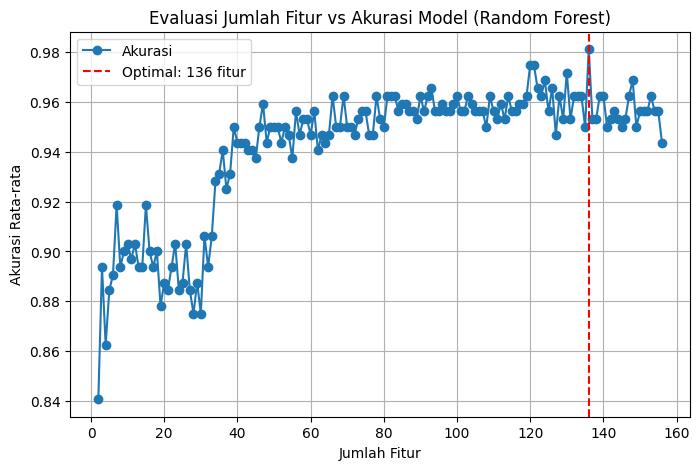

🌟 Jumlah fitur optimal: 136 dengan akurasi 0.9812


In [122]:
plot_feature_evaluation(results_df)

In [123]:
features_df.describe().loc[["min", "max"]]


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_444.44Hz,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,label_buka,label_tutup,label_fikri,label_fauzan
min,17.647803,0.018312,4.0,10.857681,0.439086,0.0,0.0,-0.203674,0.000000,0.000015,...,0.007937,0.005305,0.003407,0.002098,0.001219,744.0,0.0,0.0,0.0,0.0
max,2030.738166,0.313852,16.0,1000.456293,2.247681,13653.0,54613.0,0.000000,0.169617,0.000057,...,1.020042,0.942263,0.769304,0.579292,0.401327,12996.0,1.0,1.0,1.0,1.0


In [124]:
features_df.describe().loc[["mean", "std"]]


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_444.44Hz,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,label_buka,label_tutup,label_fikri,label_fauzan
mean,475.491686,0.117370,9.412500,211.163508,1.135094,7453.457500,29815.072500,-0.028997,0.014775,0.000028,...,0.192242,0.162426,0.126586,0.089455,0.055902,5072.917500,0.500000,0.500000,0.500000,0.500000
std,324.406760,0.050968,2.213502,171.431626,0.342033,3077.933461,12311.967411,0.036055,0.020295,0.000010,...,0.176729,0.156402,0.127105,0.094402,0.063762,2960.605704,0.500626,0.500626,0.500626,0.500626


### *Memilih Jumlah Fitur Optimal*

In [125]:
def select_top_features(feature_df, ig_scores, n_features):
    # Ambil nama kolom fitur (bukan kolom label)
    feature_columns = feature_df.drop(columns=[
        "label_buka", "label_tutup", "label_fikri", "label_fauzan",
    ]).columns

    # Pastikan ig_scores jumlah barisnya sama jumlah fitur
    ig_scores = ig_scores.copy()
    ig_scores.index = feature_columns

    # Urutkan
    score_col = ig_scores.columns[-1]
    top_features = ig_scores.sort_values(by=score_col, ascending=False).head(n_features).index

    # Return data fitur terpilih
    return feature_df[top_features]


In [126]:
def select_top_features(feature_df, ig_scores, n_features):
    # Kolom yang kemungkinan ada
    drop_cols = ["label_buka", "label_tutup", "label_fikri", "label_fauzan", "filename"]

    # Filter hanya kolom yang benar-benar ada di dataset
    drop_cols = [col for col in drop_cols if col in feature_df.columns]

    # Drop yang ada saja
    feature_columns = feature_df.drop(columns=drop_cols).columns

    # Pastikan panjang ig_scores sesuai jumlah fitur
    ig_scores = ig_scores.copy()
    ig_scores.index = feature_columns

    # Ambil top N fitur
    score_col = ig_scores.columns[-1]
    top_features = ig_scores.sort_values(by=score_col, ascending=False).head(n_features).index

    # Kembalikan dataframe dengan fitur terbaik
    return feature_df[top_features], top_features


In [127]:
optimal_n = 136

label_cols = ["label_buka", "label_tutup", "label_fikri", "label_fauzan"]
features_df_clean = features_df.drop(columns=["filename"])

X_raw = features_df_clean.drop(columns=label_cols)

X_optimal, top_features = select_top_features(X_raw, ig_score, optimal_n)

print("Jumlah fitur:", len(X_optimal.columns))
print("Daftar fitur terpilih:", top_features)

Jumlah fitur: 136
Daftar fitur terpilih: Index(['0_Absolute energy', '0_Area under the curve', '0_Autocorrelation',
       '0_Average power', '0_Centroid', '0_ECDF Percentile Count_0',
       '0_ECDF Percentile Count_1', '0_ECDF Percentile_0',
       '0_ECDF Percentile_1', '0_ECDF_0',
       ...
       '0_Wavelet absolute mean_800.0Hz', '0_Wavelet energy_1000.0Hz',
       '0_Wavelet energy_1333.33Hz', '0_Wavelet energy_2000.0Hz',
       '0_Wavelet energy_4000.0Hz', '0_Wavelet energy_444.44Hz',
       '0_Wavelet energy_500.0Hz', '0_Wavelet energy_571.43Hz',
       '0_Wavelet energy_666.67Hz', '0_Wavelet energy_800.0Hz'],
      dtype='object', length=136)


### *Melakukan Normalisai*

In [128]:
def normalize_features_minmax(df, label_cols, scaler_path="scaler_minmax.pkl"):
    X = df.drop(columns=label_cols)
    y = df[label_cols]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_optimal)
    X_scaled = pd.DataFrame(X_scaled, columns=X_optimal.columns)

    joblib.dump(scaler, scaler_path)

    return X_scaled, y, scaler

In [129]:
X_scaled, y, scaler = normalize_features_minmax(features_df_clean, label_cols)

## **Modeling Dan Evaluasi Model**

### *Traning Model*

In [130]:
def train_random_forest_multilabel(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Model multilabel
    model = MultiOutputClassifier(RandomForestClassifier(random_state=random_state))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Akurasi multilabel → hitung per label, lalu rata-rata
    accuracies = {}
    for i, col in enumerate(y.columns):
        accuracies[col] = accuracy_score(y_test.iloc[:, i], y_pred[:, i])

    avg_accuracy = sum(accuracies.values()) / len(accuracies)

    return model, accuracies, avg_accuracy

In [131]:
for i in features_df_clean.columns :
    print(i)

0_Absolute energy
0_Area under the curve
0_Autocorrelation
0_Average power
0_Centroid
0_ECDF Percentile Count_0
0_ECDF Percentile Count_1
0_ECDF Percentile_0
0_ECDF Percentile_1
0_ECDF_0
0_ECDF_1
0_ECDF_2
0_ECDF_3
0_ECDF_4
0_ECDF_5
0_ECDF_6
0_ECDF_7
0_ECDF_8
0_ECDF_9
0_Entropy
0_Fundamental frequency
0_Histogram mode
0_Human range energy
0_Interquartile range
0_Kurtosis
0_LPCC_0
0_LPCC_1
0_LPCC_10
0_LPCC_11
0_LPCC_2
0_LPCC_3
0_LPCC_4
0_LPCC_5
0_LPCC_6
0_LPCC_7
0_LPCC_8
0_LPCC_9
0_MFCC_0
0_MFCC_1
0_MFCC_10
0_MFCC_11
0_MFCC_2
0_MFCC_3
0_MFCC_4
0_MFCC_5
0_MFCC_6
0_MFCC_7
0_MFCC_8
0_MFCC_9
0_Max
0_Max power spectrum
0_Maximum frequency
0_Mean
0_Mean absolute deviation
0_Mean absolute diff
0_Mean diff
0_Median
0_Median absolute deviation
0_Median absolute diff
0_Median diff
0_Median frequency
0_Min
0_Negative turning points
0_Neighbourhood peaks
0_Peak to peak distance
0_Positive turning points
0_Power bandwidth
0_Root mean square
0_Signal distance
0_Skewness
0_Slope
0_Spectral centroid
0_S

In [132]:
rf_model, accurracy, mean_acc = train_random_forest_multilabel(X_optimal, y)

In [133]:
print(accurracy)

{'label_buka': 0.95, 'label_tutup': 0.95, 'label_fikri': 1.0, 'label_fauzan': 1.0}


In [134]:
print(mean_acc)

0.975


## **Simpan Model**

In [135]:
# import joblib

# model_package = {
#     "scaler": scaler,                   # normalizer
#     "selected_features": top_features,  # fitur terpilih hasil IG
#     "model": rf_model,                  # model akhir
# }

# joblib.dump(model_package, "saved_models/audio-multilabel(1)/model_rf_full.pkl")


In [136]:
import soundfile as sf

def predict_new_audio(
    filepath,
    model,
    selected_features,
    scaler,
    target_duration=None,  # nanti kita isi setelah tahu durasi training
    target_sr=16000        # SAMA HARUS 16000!!!
):
    print(f"\n=== Menguji file baru: {filepath} ===")

    # 1. Convert ke WAV + samakan SR = 16000
    def convert_to_wav(path, target_sr):
        signal, sr = librosa.load(path, sr=target_sr, mono=True)
        temp_out = "temp_converted.wav"
        sf.write(temp_out, signal, target_sr)
        return temp_out, signal, target_sr

    temp_wav, signal, sr = convert_to_wav(filepath, target_sr)

    print(f"Audio converted to WAV | SR = {sr}, Samples = {len(signal)}")

    # 2. Jika training memakai durasi tetap → kita samakan
    if target_duration is not None:
        target_len = int(target_duration * sr)
        if len(signal) > target_len:
            signal = signal[:target_len]
        else:
            signal = np.pad(signal, (0, target_len - len(signal)))

    print("Duration =", len(signal)/sr)


    print("Mean =", np.mean(signal))
    print("Std  =", np.std(signal))
    print("RMS  =", np.sqrt(np.mean(signal**2)))


    # 3. Masukkan ke TSFEL
    data_list = [{
        'signal': signal,
        'sampling_rate': sr,
        'filename': filepath,
        'label_buka': None,
        'label_tutup': None,
        'label_fikri': None,
        'label_fauzan': None
    }]

    # 4. Ekstrak fitur
    features_df = extract_features_tsfel(data_list)

    # 5. Seleksi fitur sesuai training
    try:
        selected_df = features_df[selected_features]
    except Exception as e:
        print("\n❌ ERROR seleksi fitur:")
        print(e)
        print("\n👉 Penyebab: Durasi atau SR testing masih tidak cocok.")
        return None

    # 6. Normalisasi
    scaled = pd.DataFrame(
        scaler.transform(selected_df),
        columns=selected_features
    )

    # 7. Prediksi
    pred = model.predict(scaled)

    print("\n=== Hasil Prediksi ===")
    print(pred)

    return pred

In [137]:
filepath = "dataset/audio/buka fikri/voice-recorder-2025-11-02--13-08-50.mp3"   # Bebas format

prediksi = predict_new_audio(
    filepath=filepath,
    model=rf_model,               # model kamu
    selected_features=top_features,
    scaler=scaler
)


=== Menguji file baru: dataset/audio/buka fikri/voice-recorder-2025-11-02--13-08-50.mp3 ===
Audio converted to WAV | SR = 16000, Samples = 50518
Duration = 3.157375
Mean = -8.297518e-06
Std  = 0.11388169
RMS  = 0.11388169

Memulai proses ekstraksi fitur TSFEL untuk 1 file...



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Ekstraksi fitur selesai!
Total data fitur: 1 baris, 161 kolom

=== Hasil Prediksi ===
[[1 0 0 1]]
